# Distance Measurement between images pairs

to - do : create image positive negative image pairs with anchors in regards to cleanedSwire (512x512) and cleanedRICO512 (512x512) 

In [41]:
# needed imports 
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import keras_toolkit as kt
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
# for channel conversion
import cv2
import numpy as np
import glob

# bokeh packages
from bokeh.io import output_file,show,output_notebook,push_notebook
from bokeh.plotting import *
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper
from bokeh.layouts import row,column,gridplot,widgetbox
from bokeh.models.widgets import Tabs,Panel

to - do: 
creation of a seameese network using tripplet loss with the image p/n anchor pairs. 

# Define Image Paths

In [2]:
golden_csv = pd.read_csv('C:/Users/hkhai/Documents/GAN/Distance_measure/golden.csv')

In [3]:
golden_csv.head()

,anchorP,positiveP
0,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
1,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
2,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
3,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
4,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...


In [4]:
anchor_images = golden_csv['anchorP'].tolist()
positive_images = golden_csv['positiveP'].tolist()

# pre processing images to be used in the network size 256x256

In [5]:
target_shape = (256,256)
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [6]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)


In [7]:
#import channels to run channel checker should be all channel 3 if 1 conversion 
#!python channels.py --source=C:/Users/hkhai/Documents/GAN/Distance_measure/UI_ss/UI_ss --dest=C:/Users/hkhai/Documents/GAN/Distance_measure/deletemeRICO --width=256 --height=256
#!del deletemeRICO /Q

In [8]:
# and again with the sketch data, this one is likely to have issues
#!python channels.py --source=C:/Users/hkhai/Documents/GAN/Distance_measure/swire/sketches/sketches --dest=C:/Users/hkhai/Documents/GAN/Distance_measure/deletemeSk --width=256 --height=256
#!del deletemeSk /Q

In [9]:
# if issues occure above^ transform data to color aka 3 channels do not save to data transformation of stylegan2-ada-pytorch it isnt needed.
#sketches = 'C:/Users/hkhai/Documents/GAN/Distance_measure/swire/sketches/sketches/*.jpg'
#for infile in tqdm(glob.glob(sketches), total=image_count):
    #img = cv2.imread(infile)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img2 = np.zeros_like(img)
    #img2[:,:,0] = gray
    #img2[:,:,1] = gray
    #img2[:,:,2] = gray
    #cv2.imwrite(infile, img2)

In [10]:
# generate the list of negative images, randomize the list of
# available images and concatenate them together.
testset = positive_images + anchor_images
np.random.shuffle(testset)
testset 

def extract(lst):
    returnMe = []
    count = 0
    for obj in lst:
        if (count < 3551):
            returnMe.append(obj)
        count =count +1 
        
    return returnMe # sublist of testset for randomization

negatives = extract(testset)
np.random.shuffle(negatives)

In [11]:
golden_csv['negative'] =negatives

In [12]:
golden_csv= golden_csv.rename(columns = {"anchorP":"anchor", "positiveP":"positive"})
golden_csv.head()

,anchor,positive,negative
0,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
1,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
2,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
3,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...
4,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...,C:/Users/hkhai/Documents/GAN/Distance_measure/...


In [13]:
train_paths, val_paths = train_test_split(golden_csv, train_size=0.8, random_state=42)
strategy = kt.accelerator.auto_select(verbose=True)
BATCH_SIZE = strategy.num_replicas_in_sync * 16

Running on 1 replicas


In [14]:
dtrain = kt.image.build_dataset(
    (train_paths.anchor, train_paths.positive, train_paths.negative), 
    decode_fn=preprocess_triplets,
    bsize=BATCH_SIZE,
    augment=False,
    repeat=False
)

dvalid = kt.image.build_dataset(
    (val_paths.anchor, val_paths.positive, val_paths.negative), 
    decode_fn=preprocess_triplets,
    bsize=BATCH_SIZE,
    augment=False,
    repeat=False
)

In [15]:
def get_layers_output_by_name(model,layer_names):
        return {v: model.get_layer(v).output for v in layer_names}

In [16]:
with strategy.scope():
    vgg_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_shape + (3,))
    for layer in vgg_model.layers[:10]:
            layer.trainable = False
    intermediate_layer_outputs = get_layers_output_by_name(vgg_model, 
                                                        ["block1_pool", "block2_pool", "block3_pool", "block4_pool"])
    convnet_output = layers.GlobalAveragePooling2D()(vgg_model.output)
    for layer_name, output in intermediate_layer_outputs.items():
            output = layers.GlobalAveragePooling2D()(output)
            convnet_output = layers.concatenate([convnet_output, output])
    convnet_output = layers.Dense(512, activation = 'relu')(convnet_output)
    convnet_output = layers.Dropout(0.6)(convnet_output)
    convnet_output = layers.Dense(512, activation = 'relu')(convnet_output)
    #convnet_output = layers.Dropout(0.5)(convnet_output)
    convnet_output = layers.Lambda(lambda p: K.l2_normalize(p,axis=1))(convnet_output)
    
    #embedding= Model(inputs=[anchor_input, positive_input, vgg_model.input], outputs=convnet_output)
    embedding= Model(inputs=[vgg_model.input], outputs=convnet_output,name="Embedding")

In [19]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


with strategy.scope():
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(vgg16.preprocess_input(anchor_input)),
        embedding(vgg16.preprocess_input(positive_input)),
        embedding(vgg16.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )

In [20]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The Contrastive Loss is defined as:
       L(θ) = (1-y)(1/2)D(Xq, Xp)^2 + y(1/2){max(0, m - D(Xq, Xn)^2)}
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        loss = tf.convert_to_tensor(0,dtype=tf.float32)
        g = tf.constant(1.0, shape=[1], dtype=tf.float32)
        h = tf.constant(0.0, shape=[1], dtype=tf.float32)
        
        def _contrastive_loss(y_true, y_pred):
            return tfa.losses.contrastive_loss(y_true, y_pred)
        
        ap_distance, an_distance = self.siamese_network(data)
        loss_query_pos = _contrastive_loss(g, ap_distance)
        loss_query_neg = _contrastive_loss(h, an_distance)
        loss = loss + loss_query_pos + loss_query_neg

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        #loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [21]:
class SiameseModelExperiment(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.
    """

    def __init__(self, network, margin=0.5, batch_size=32):
        super(SiameseModel, self).__init__()
        self.model = network
        self.margin = margin
        self.batch_size = batch_size
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.model(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            q_emd = self.model((data[0], data[0], data[0]), training = True)
            p_emd = self.model((data[1], data[1], data[1]), training = True)
            n_emd = self.model((data[2], data[2], data[2]), training = True)
            loss_value = self.contrastive_loss_function(q_emd, p_emd, n_emd, self.batch_size)
            accuracy_value = self.accuracy(q_emd, p_emd, n_emd, self.batch_size)

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return {"loss": loss_value, "acc":accuracy_value}
    
    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def contrastive_loss_function(self, q_emd, p_emd, n_emd, batch_size):
        '''
          Ref: https://github.com/gofynd/mildnet/blob/master/trainer/loss.py
          This function takes embedding generated by model for each of the image
          part of the triplet and return the loss value for the batch.
          q_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
          p_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
          n_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
          batch_size(input): batch size for each step
          loss(output): Final loss for a batch
        '''
        def _contrastive_loss(y_true, y_pred):
            return tfa.losses.contrastive_loss(y_true, y_pred)

        loss = tf.convert_to_tensor(0,dtype=tf.float32)
        g = tf.constant(1.0, shape=[1], dtype=tf.float32)
        h = tf.constant(0.0, shape=[1], dtype=tf.float32)

        for obs_num in range(batch_size):
            dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - p_emd[obs_num])**2))
            dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - n_emd[obs_num])**2))
            loss_query_pos = _contrastive_loss(g, dist_query_pos)
            loss_query_neg = _contrastive_loss(h, dist_query_neg)
            loss = loss + loss_query_pos + loss_query_neg

        loss = loss/(batch_size*2)
        zero = tf.constant(0.0, shape=[1], dtype=tf.float32)
        return tf.maximum(loss, zero)
    
    def accuracy(self, q_emd, p_emd, n_emd, batch_size):
        '''
          Ref: https://github.com/gofynd/mildnet/blob/master/trainer/accuracy.py
          This function takes in embedding and return the accuracy value for the batch
          q_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
          p_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
          n_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
          batch_size(input): batch size for each step
          accuracy(output): Final accuracy value for a batch
        '''
        accuracy = 0
        for obs_num in range(batch_size):
            dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - p_emd[obs_num])**2))
            dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - n_emd[obs_num])**2))
            accuracy += tf.cond(dist_query_neg > dist_query_pos, lambda : 1, lambda : 0)

        return (accuracy * 100) / batch_size

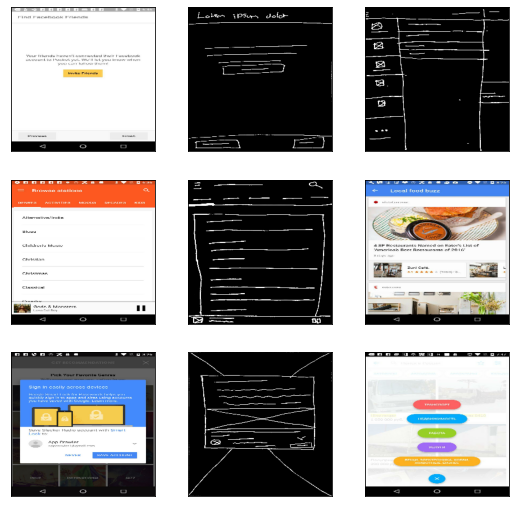

In [57]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(dtrain.take(1).as_numpy_iterator())[0])

# training

In [22]:
with strategy.scope():
    siamese_model = SiameseModel(siamese_network)
    #siamese_model.compile(optimizer=optimizers.Adam(0.0001))
    siamese_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001))

hist = siamese_model.fit(dtrain, epochs=20, validation_data=dvalid)

Epoch 1/20
178/178 [==============================] - 1990s 11s/step - loss: 1.5006 - val_loss: 1.5000
Epoch 2/20
178/178 [==============================] - 2008s 11s/step - loss: 1.5070 - val_loss: 1.5000
Epoch 3/20
178/178 [==============================] - 1984s 11s/step - loss: 1.5025 - val_loss: 1.4490
Epoch 4/20
178/178 [==============================] - 1964s 11s/step - loss: 1.3384 - val_loss: 1.0696
Epoch 5/20
178/178 [==============================] - 1965s 11s/step - loss: 1.0945 - val_loss: 0.9889
Epoch 6/20
178/178 [==============================] - 1976s 11s/step - loss: 0.9885 - val_loss: 0.9312
Epoch 7/20
178/178 [==============================] - 2004s 11s/step - loss: 0.9507 - val_loss: 0.9311
Epoch 8/20
178/178 [==============================] - 1980s 11s/step - loss: 0.9088 - val_loss: 0.8996
Epoch 9/20
178/178 [==============================] - 2031s 11s/step - loss: 0.8795 - val_loss: 0.8527
Epoch 10/20
178/178 [==============================] - 2008s 11s/step - l

In [23]:
siamese_model.save_weights('siamese_model.h5')
siamese_model.siamese_network.save_weights('siamese_network.h5')
embedding_net = siamese_model.siamese_network.get_layer("Embedding")
embedding_net.save_weights('embedding_net.h5')

In [30]:
hist

# embedding

In [75]:
from io import BytesIO
import base64

def embeddable_image(img):
    img = img.split('/')[-1]
    if(os.path.exists('C:/Users/hkhai/Documents/GAN/Distance_measure/UI_ss/'+img)): # if real exisits
        img = 'C:/Users/hkhai/Documents/GAN/Distance_measure/UI_ss/'+img
    elif(os.path.exists('C:/Users/hkhai/Documents/GAN/Distance_measure/swire/sketches/'+img)): # if sketch exisits
        img = 'C:/Users/hkhai/Documents/GAN/Distance_measure/swire/sketches/'+img
    else: 
        print("image not found")
        
    data = Image.open(img)
    data =np.asarray(data)
    
    img_data = data.astype(np.uint8)
    image = Image.fromarray(img_data).resize((50,50), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [34]:
pred = model.predict(dvalid)
pred = np.nan_to_num(pred)

In [58]:
data_valid = golden_csv
data_valid =data_valid.loc[val_paths.index,:].reset_index(drop=True)
data_valid2 =val_paths.reset_index(drop=True)

In [63]:
pred

array([[0.        , 0.00725231, 0.        , ..., 0.        , 0.        ,
        0.04942467],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10276573],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08066139],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08279438],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06660102],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08503652]], dtype=float32)

# Computing average similarity distance between dtrain set baseline

In [95]:
pos_pair_sim = []
neg_pair_sim = []
t = len(dtrain)

for sample in tqdm(dtrain, total =t):

    anchor, positive, negative = sample
    anchor_embedding, positive_embedding, negative_embedding = (
        (embedding_net(anchor)),
        (embedding_net(positive)),
        (embedding_net(negative)),
    )

    cosine_similarity = metrics.CosineSimilarity()

    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    #print("Positive similarity:", positive_similarity.numpy())
    pos_pair_sim.append(positive_similarity)

    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    #print("Negative similarity", negative_similarity.numpy())
    neg_pair_sim.append(negative_similarity)

100%|██████████| 178/178 [20:27<00:00,  6.90s/it]


In [96]:
import statistics
pps=[]
for i in pos_pair_sim:
    i = i.numpy()
    pps.append(i)
    
print("positive average distance:",statistics.mean(pps))

nps=[]
for i in neg_pair_sim:
    i = i.numpy()
    nps.append(i)  
    
print("negative average distance:",statistics.mean(nps))

positive average distance: 0.962952
negative average distance: 0.95551467


In [98]:
pos_pair_simvalid = []
neg_pair_simvalid = []
t = len(dvalid)

for sample in tqdm(dvalid, total =t):

    anchor, positive, negative = sample
    anchor_embedding, positive_embedding, negative_embedding = (
        (embedding_net(anchor)),
        (embedding_net(positive)),
        (embedding_net(negative)),
    )

    cosine_similarity = metrics.CosineSimilarity()

    positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
    #print("Positive similarity:", positive_similarity.numpy())
    pos_pair_simvalid.append(positive_similarity)

    negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
    #print("Negative similarity", negative_similarity.numpy())
    neg_pair_simvalid.append(negative_similarity)

100%|██████████| 45/45 [05:15<00:00,  7.02s/it]


In [100]:
pps_v=[]
for i in pos_pair_simvalid:
    i = i.numpy()
    pps_v.append(i)
    
print("positive average distance validation set:",statistics.mean(pps_v))
nps_v=[]
for i in neg_pair_simvalid:
    i = i.numpy()
    nps_v.append(i)
    
print("negative average distance validation set:", statistics.mean(nps_v))

positive average distance validation set: 0.961512
negative average distance validation set: 0.9552503


# data visualization --bokeh

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [37]:
scale = preprocessing.StandardScaler()
X = scale.fit_transform(pred)
X_norm = preprocessing.normalize(X)

pca_N = PCA(n_components=2)
principalComponents_N = pca_N.fit_transform(X_norm)

In [43]:
# initial source
source = ColumnDataSource(data=dict(
    x = principalComponents_N[:, 0],
    y = principalComponents_N[:, 1],
    x_backup = principalComponents_N[:, 0],
    y_backup = principalComponents_N[:, 1],
    anchor = data_valid.anchor,
    positive = data_valid.positive,
    negative = data_valid.negative
))

# hover tool
hover = HoverTool(tooltips = [("anchor","@anchor"),("positive","@positive"),("negative","@negative")],
                 point_policy="follow_mouse")

# plotting
plot=figure(title ="PCA Visualization",
            plot_width=900, plot_height=900, 
            tools=[hover,"crosshair","pan","box_zoom","wheel_zoom", "reset"])
# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          
          line_alpha=0.3,
          line_color="black")

# this is different from what we learn up to now.
# update method: When slider is changed or when different value from drop down tool is chosen this method is called.
# In this method x and y axis are updated from drop dawn value and year is updated from slider value.
show(plot,notebook_handle=True)

In [53]:
# initial source
source = ColumnDataSource(data=dict(
    x = principalComponents_N[:, 0],
    y = principalComponents_N[:, 1],
    x_backup = principalComponents_N[:, 0],
    y_backup = principalComponents_N[:, 1],
    anchor = data_valid.anchor,
    image = list(map(embeddable_image, data_valid2.anchor))
))

# hover tool
#hover = HoverTool(tooltips = [("anchor","@anchor"),("positive","@positive"),("negative","@negative")],
#                 point_policy="follow_mouse")

# plotting
plot=figure(title ="PCA Visualization with Anchor Images",
            plot_width=900, plot_height=850, 
            tools=["pan", "wheel_zoom", "reset","crosshair","box_zoom"])

plot.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 30px 30px 30px 30px'/>
    </div>
    <div>
        <span style='font-size: 10px; color: #224499'>Anchor:</span>
        <span style='font-size: 10px'>@anchor</span>
    </div>
</div>
"""))

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          
          line_alpha=0.3,
          line_color="black")

# this is different from what we learn up to now.
# update method: When slider is changed or when different value from drop down tool is chosen this method is called.
# In this method x and y axis are updated from drop dawn value and year is updated from slider value.
show(plot,notebook_handle=True) 

In [54]:
from sklearn.manifold import TSNE

pca_50 = PCA(n_components=5)
principalComponents_50 = pca_50.fit_transform(pred)

tsne_50 = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=50, n_iter=300).fit_transform(principalComponents_50)

In [55]:
# initial source
sourceA = ColumnDataSource(data=dict(
    x = tsne_50[:, 0],
    y = tsne_50[:, 1],
    x_backup = tsne_50[:, 0],
    y_backup = tsne_50[:, 1],
    anchor = data_valid.anchor,
    positive = data_valid.positive,
    negative = data_valid.negative
))

# hover tool
hoverA = HoverTool(tooltips = [("anchor","@anchor"),("positive","@positive"),("negative","@negative")],
                 point_policy="follow_mouse")

# plotting
plotA=figure(title ="TSNE on PCA Visualization",
            plot_width=900, plot_height=850, 
            tools=[hoverA,"crosshair","pan","box_zoom"])
# plot settings
plotA.scatter('x', 'y', size=5, 
          source=sourceA,
          
          line_alpha=0.3,
          line_color="black")

# this is different from what we learn up to now.
# update method: When slider is changed or when different value from drop down tool is chosen this method is called.
# In this method x and y axis are updated from drop dawn value and year is updated from slider value.
show(plotA,notebook_handle=True)